In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!unzip -qq 'drive/MyDrive/minor_project/augmented_dataset.zip' -d 'dataset/'

In [3]:
!ls dataset

final_1


In [4]:
!ls dataset/final_1

test  train  val


In [5]:
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
import timeit
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix)
import cv2

In [6]:
np.random.seed(12049)

In [7]:
def get_classes(data_path, classes, data):
    print(f"----{data}----")
    knee_severity={}
    count=0

    for i in range(len(classes)):
        imgs=os.listdir(os.path.join(data_path, str(i)))
        knee_severity[i]=imgs
        count+=len(imgs)

    for k, v in knee_severity.items():
        print(
            f"Grade {k}-{classes[k]}: {len(v)} images, {round((len(v)*100)/count, 2)}%"
        )

    return knee_severity

def plot_classes(dict_classes, data_path, classes, data):
    for k, v in dict_classes.items():
        print(f"{data}-{classes[k]}")
        plt.figure(figsize=(10, 25))
        for i in range(5):
            img_path=os.path.join(data_path, str(k), v[i])
            img=tf.keras.preprocessing.image.load_img(img_path)
            plt.subplot(1, 5, 1+i, xticks=[], yticks=[])
            plt.imshow(img)
            plt.title(f"Grade {k}")
        plt.show()

In [8]:
class_names=['Healthy', 'Doubtful', 'Minimal', 'Moderate', 'Severe']

In [9]:
base_dir="dataset/final_1/"
train_path=os.path.join(base_dir, 'train')
valid_path=os.path.join(base_dir, 'val')
test_path=os.path.join(base_dir, 'test')

In [10]:
train_data=get_classes(train_path, class_names, 'Train')
valid_data=get_classes(valid_path, class_names, 'Valid')
test_data=get_classes(test_path, class_names, 'Test')

----Train----
Grade 0-Healthy: 2286 images, 20.36%
Grade 1-Doubtful: 2262 images, 20.15%
Grade 2-Minimal: 2270 images, 20.22%
Grade 3-Moderate: 2228 images, 19.85%
Grade 4-Severe: 2180 images, 19.42%
----Valid----
Grade 0-Healthy: 328 images, 39.71%
Grade 1-Doubtful: 153 images, 18.52%
Grade 2-Minimal: 212 images, 25.67%
Grade 3-Moderate: 106 images, 12.83%
Grade 4-Severe: 27 images, 3.27%
----Test----
Grade 0-Healthy: 639 images, 38.59%
Grade 1-Doubtful: 296 images, 17.87%
Grade 2-Minimal: 447 images, 26.99%
Grade 3-Moderate: 223 images, 13.47%
Grade 4-Severe: 51 images, 3.08%


Train data-Healthy


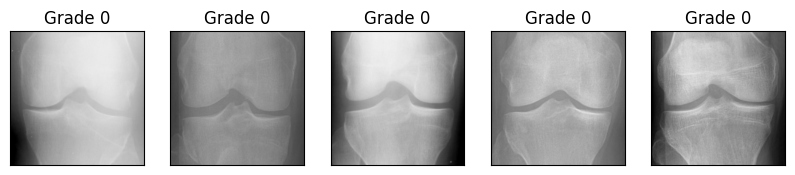

Train data-Doubtful


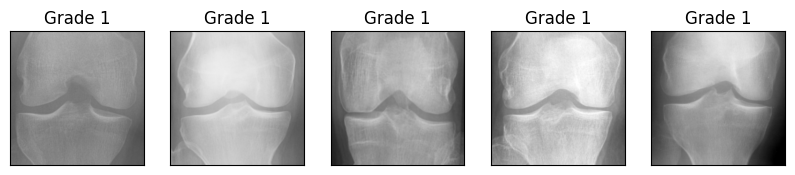

Train data-Minimal


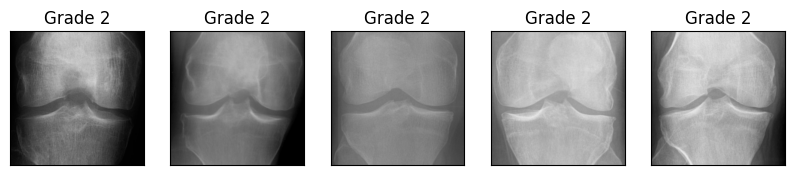

Train data-Moderate


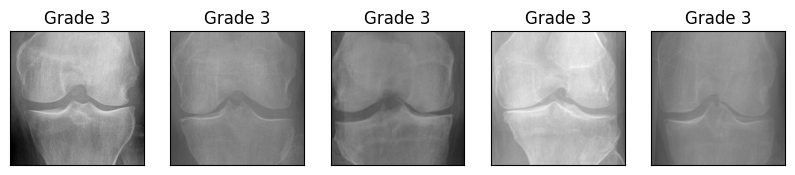

Train data-Severe


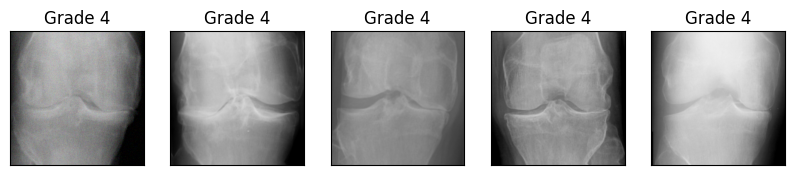

In [11]:
plot_classes(train_data, train_path, class_names, 'Train data')

In [12]:
def get_plot_loss_acc(model, model_name):
    fig=plt.figure()
    plt.subplot(2, 1, 1)
    plt.plot(model.history.history["loss"])
    plt.plot(model.history.history["val_loss"])
    plt.title(f"{model_name} \n\n model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "valid"], loc="upper right")

    plt.subplot(2, 1, 2)
    plt.plot(model.history.history["accuracy"])
    plt.plot(model.history.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "valid"], loc="lower right")

    plt.tight_layout()

def compute_confusion_matrix(ytrue, ypred, class_names, model_name):
    cm=confusion_matrix(
        y_true=ytrue.labels,
        y_pred=np.argmax(ypred, axis=1),
    )
    cmn=cm.astype("float")/cm.sum(axis=1)[:, np.newaxis]
    plt.subplots(figsize=(6, 5))
    sns.heatmap(
        cmn,
        annot=True,
        fmt=".2f",
        cmap="Purples",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.title(f"Confusion Matrix - {model_name}")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show(block=False)

def get_evaluate(data, name, model):
    score_model=model.evaluate(data, verbose=1)
    print(f"{name} loss: {score_model[0]: .2f}")
    print(f"{name} accuracy: {score_model[1]: .2f}")

def get_predict(data, model):
    predict_model=model.predict(data)
    return predict_model

def get_metrics(y_test, y_pred, model_name):
    acc=accuracy_score(y_test, y_pred)
    bal_acc=balanced_accuracy_score(y_test, y_pred)

    print(f"Accuracy Score - {model_name}: {acc: .2f}")
    print(f"Balanced Accuracy Score - {model_name}: {bal_acc: .2f}")
    print("\n")

    print(classification_report(y_test, y_pred))

In [13]:
model_name="Resnet50"

target_size=(224, 224)
epochs=20
batch_size=256
img_shape=(224, 224, 3)

save_model_ft=os.path.join('models', f'model_{model_name}_ft.hdf5')

In [14]:
def apply_clahe(image):
    # Convert the image to grayscale (8-bit unsigned, single-channel)
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Ensure the image is in CV_8UC1 format
    if gray_image.dtype != np.uint8:
        gray_image = np.uint8(gray_image)

    # Apply CLAHE to the grayscale image
    clahe = cv2.createCLAHE(clipLimit=40.0, tileGridSize=(8, 8))
    enhanced_image = clahe.apply(gray_image)

    # Convert the enhanced grayscale image back to RGB color space
    enhanced_rgb = cv2.cvtColor(enhanced_image, cv2.COLOR_GRAY2RGB)

    return enhanced_rgb

Found 11226 images belonging to 5 classes.


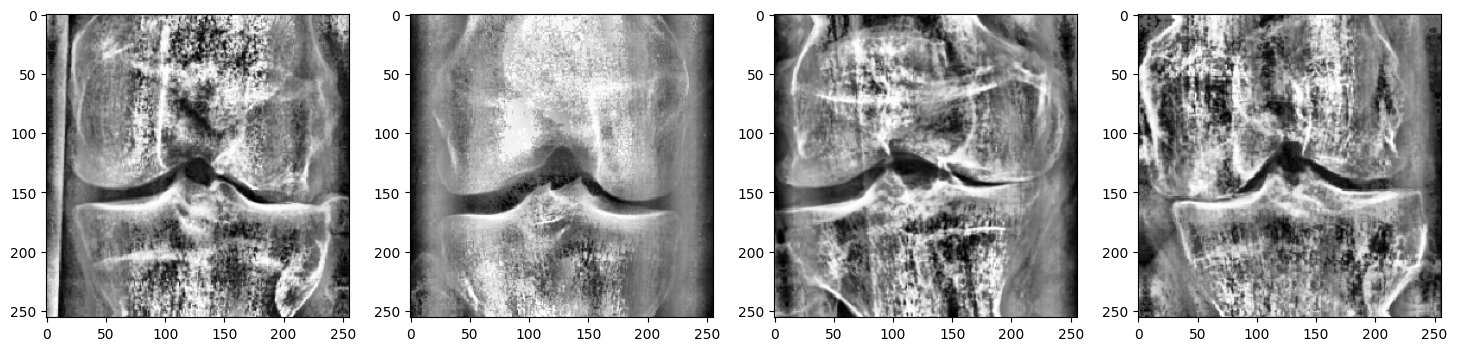

In [15]:
datagen=tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=lambda x: apply_clahe(x),
)
imagegen=datagen.flow_from_directory(train_path, batch_size=1)
fig, rows=plt.subplots(nrows=1, ncols=4, figsize=(18, 18))
for row in rows:
    row.imshow(imagegen.next()[0][0].astype("uint8"))
plt.show()

In [16]:
aug_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=lambda x: apply_clahe(x),
)

noaug_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=lambda x: apply_clahe(x),
)

In [17]:
train_generator = aug_datagen.flow_from_directory(
    train_path, class_mode="categorical", target_size=target_size, shuffle=True
)

valid_generator = noaug_datagen.flow_from_directory(
    valid_path,
    class_mode="categorical",
    target_size=target_size,
    shuffle=False,
)

Found 11226 images belonging to 5 classes.
Found 826 images belonging to 5 classes.


In [18]:
y_train = train_generator.labels
y_val = valid_generator.labels

In [19]:
unique, counts = np.unique(y_train, return_counts=True)
print("Train: ", dict(zip(unique, counts)))

class_weights = compute_class_weight(
    class_weight="balanced", classes=np.unique(y_train), y=y_train
)
train_class_weights = dict(enumerate(class_weights))
print(train_class_weights)

Train:  {0: 2286, 1: 2262, 2: 2270, 3: 2228, 4: 2180}
{0: 0.9821522309711286, 1: 0.9925729442970822, 2: 0.9890748898678414, 3: 1.0077199281867146, 4: 1.0299082568807338}


In [20]:
model = tf.keras.applications.ResNet50(
    input_shape=(img_shape),
    include_top=False,
    weights="imagenet",
)

94765736/94765736 [==============================] - 0s 0us/step


In [21]:
for layer in model.layers:
    layer.trainable = True

model_ft = tf.keras.models.Sequential(
    [
        model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(5, activation="softmax"),
    ]
)

model_ft.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 5)                 10245     
                                                                 
Total params: 23597957 (90.02 MB)
Trainable params: 23544837 (89.82 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [22]:
model_ft.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)

start_ft = timeit.default_timer()

history = model_ft.fit(
    train_generator,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=valid_generator,
    class_weight=train_class_weights,
    verbose=1,
)

stop_ft = timeit.default_timer()

Epoch 1/20
351/351 [==============================] - 167s 347ms/step - loss: 1.0612 - accuracy: 0.5391 - val_loss: 7.1416 - val_accuracy: 0.3983
Epoch 2/20
351/351 [==============================] - 119s 339ms/step - loss: 0.7886 - accuracy: 0.6601 - val_loss: 1.2724 - val_accuracy: 0.3826
Epoch 3/20
351/351 [==============================] - 121s 344ms/step - loss: 0.6891 - accuracy: 0.7003 - val_loss: 1.1664 - val_accuracy: 0.5157
Epoch 4/20
351/351 [==============================] - 121s 344ms/step - loss: 0.6327 - accuracy: 0.7261 - val_loss: 2.5965 - val_accuracy: 0.3414
Epoch 5/20
351/351 [==============================] - 121s 344ms/step - loss: 0.5576 - accuracy: 0.7624 - val_loss: 0.8574 - val_accuracy: 0.6489
Epoch 6/20
351/351 [==============================] - 121s 344ms/step - loss: 0.4919 - accuracy: 0.8014 - val_loss: 11.0125 - val_accuracy: 0.2494
Epoch 7/20
351/351 [==============================] - 123s 350ms/step - loss: 0.4215 - accuracy: 0.8289 - val_loss: 2.0205 

In [23]:
execution_time_ft = (stop_ft - start_ft) / 60
print(
    f"Model {model_name} fine tuning executed in {execution_time_ft:.2f} minutes"
)

Model Resnet50 fine tuning executed in 47.21 minutes


In [24]:
model_ft.save(save_model_ft)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


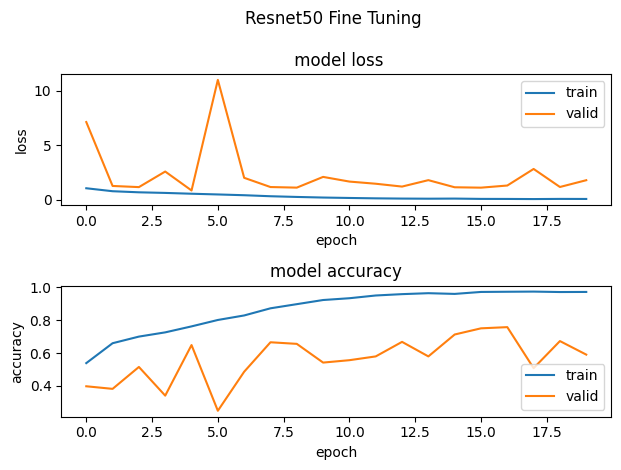

In [25]:
get_plot_loss_acc(model_ft, f"{model_name} Fine Tuning")

In [26]:
get_evaluate(valid_generator, "Valid", model_ft)

26/26 [==============================] - 4s 137ms/step - loss: 1.8001 - accuracy: 0.5908
Valid loss:  1.80
Valid accuracy:  0.59


In [27]:
predict_model_ft = get_predict(valid_generator, model_ft)

get_metrics(
    valid_generator.labels,
    y_pred=np.argmax(predict_model_ft, axis=1),
    model_name=model_name,
)

26/26 [==============================] - 4s 114ms/step
Accuracy Score - Resnet50:  0.59
Balanced Accuracy Score - Resnet50:  0.60


              precision    recall  f1-score   support

           0       0.87      0.46      0.60       328
           1       0.42      0.65      0.51       153
           2       0.51      0.86      0.64       212
           3       0.91      0.37      0.52       106
           4       1.00      0.67      0.80        27

    accuracy                           0.59       826
   macro avg       0.74      0.60      0.61       826
weighted avg       0.70      0.59      0.59       826



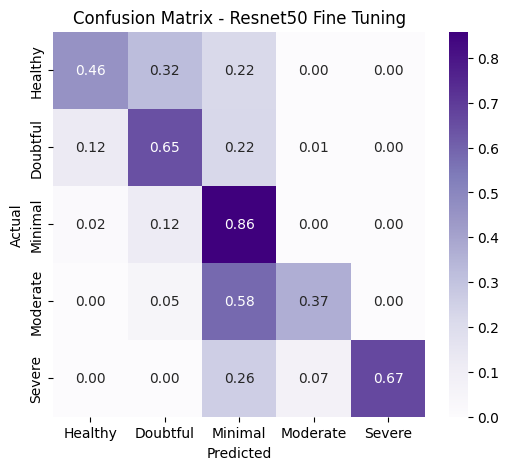

In [28]:
compute_confusion_matrix(
    valid_generator, predict_model_ft, class_names, f"{model_name} Fine Tuning"
)

In [29]:
test_generator = noaug_datagen.flow_from_directory(
    test_path,
    batch_size=batch_size,
    class_mode="categorical",
    target_size=target_size,
    shuffle=False,
)

Found 1656 images belonging to 5 classes.


In [30]:
y_test = test_generator.labels

In [31]:
get_evaluate(test_generator, "Test", model_ft)

7/7 [==============================] - 16s 1s/step - loss: 1.8008 - accuracy: 0.5851
Test loss:  1.80
Test accuracy:  0.59


In [32]:
test_model_ft=get_predict(test_generator, model_ft)

get_metrics(
    test_generator.labels,
    y_pred = np.argmax(test_model_ft, axis=1),
    model_name=model_name
)

7/7 [==============================] - 8s 1s/step
Accuracy Score - Resnet50:  0.59
Balanced Accuracy Score - Resnet50:  0.59


              precision    recall  f1-score   support

           0       0.86      0.45      0.59       639
           1       0.37      0.57      0.45       296
           2       0.53      0.85      0.66       447
           3       0.90      0.45      0.60       223
           4       0.92      0.65      0.76        51

    accuracy                           0.59      1656
   macro avg       0.72      0.59      0.61      1656
weighted avg       0.69      0.59      0.59      1656



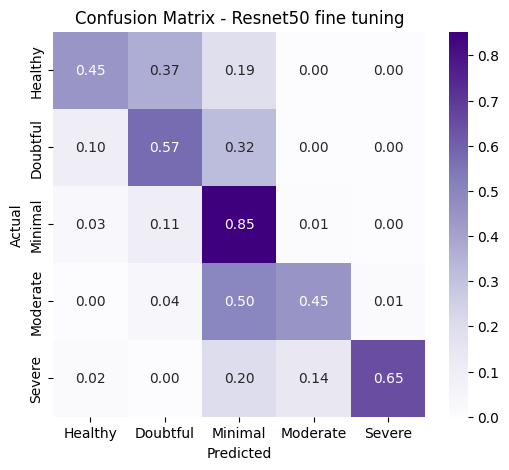

In [33]:
compute_confusion_matrix(
    test_generator,
    test_model_ft,
    class_names,
    f"{model_name} fine tuning",
)

In [34]:
def make_gradcam_heatmap(grad_model, img_array, pred_index=None):
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


def save_and_display_gradcam(img, heatmap, alpha=0.4):
    heatmap = np.uint8(255 * heatmap)

    jet = cm.get_cmap("jet")

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(
        superimposed_img
    )

    return superimposed_img

In [35]:
tests_data = get_classes(test_path, class_names, 'test')

----test----
Grade 0-Healthy: 639 images, 38.59%
Grade 1-Doubtful: 296 images, 17.87%
Grade 2-Minimal: 447 images, 26.99%
Grade 3-Moderate: 223 images, 13.47%
Grade 4-Severe: 51 images, 3.08%


In [36]:
# Last layer
conv_output = model_ft.get_layer("global_average_pooling2d").input

grad_model = tf.keras.models.Model(
    [model_ft.inputs], [conv_output, model_ft.output]
)

# model
model_ft.layers[-1].activation = None

Test data - Healthy


<ipython-input-34-2d181d1b2dd0>:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


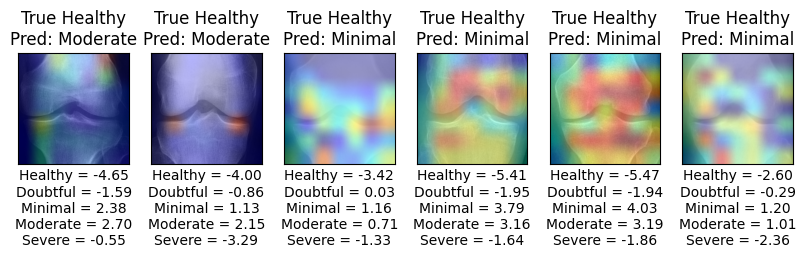

Test data - Doubtful


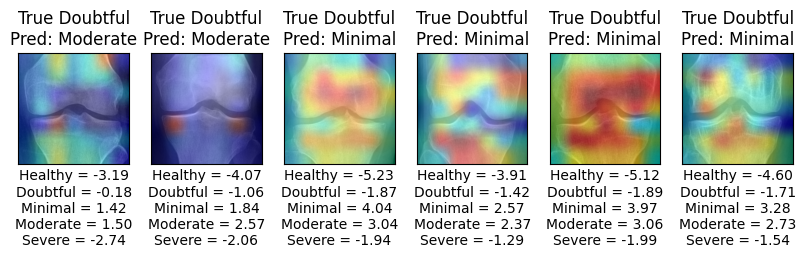

Test data - Minimal


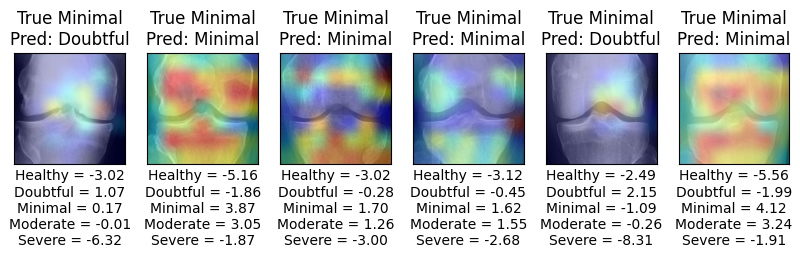

Test data - Moderate


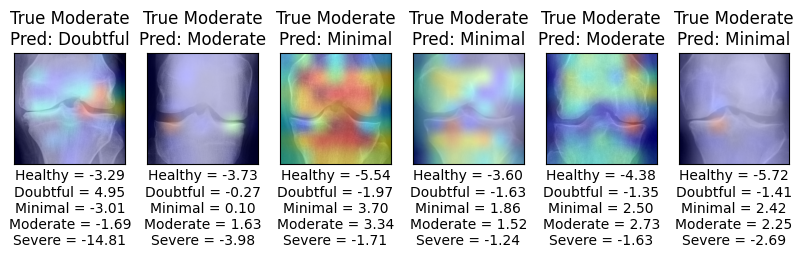

Test data - Severe


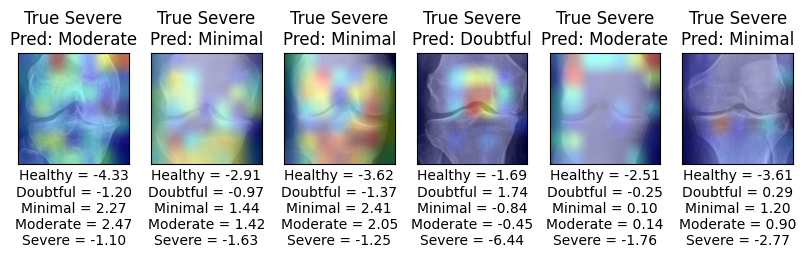

In [37]:
for k, v in tests_data.items():
    print(f"Test data - {class_names[k]}")
    plt.figure(figsize=(10, 28))
    for i in range(6):
        img_path = os.path.join(test_path, str(k), v[i])
        # prepare image
        img = tf.keras.preprocessing.image.load_img(
            img_path, target_size=target_size
        )
        img = tf.keras.preprocessing.image.img_to_array(img)

        img_aux = img.copy()
        img_array = np.expand_dims(img_aux, axis=0)
        img_array = np.float32(img_array)
        img_array = tf.keras.applications.resnet50.preprocess_input(img_array)

        y_pred = model_ft.predict(img_array, verbose=0)[0]

        heatmap = make_gradcam_heatmap(grad_model, img_array)
        image = save_and_display_gradcam(img, heatmap)

        plt.subplot(1, 6, 1 + i, xticks=[], yticks=[])
        plt.imshow(image)
        plt.title(
            f"True {class_names[k]}\nPred: {class_names[np.argmax(y_pred)]}"
        )
        plt.xlabel(
            "\n".join([f"{c} = {p:.2f}" for c, p in zip(class_names, y_pred)])
        )
    plt.show()